In [1]:
import pandas as pd
import numpy as np
from random import randint
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import math
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [2]:
%%html
<style>
table {float:left}
</style>

In [1]:
from sklearn.datasets import load_digits
digits = load_digits(n_class=10)
print type(digits)

<class 'sklearn.datasets.base.Bunch'>


---

(Continuing from [here](https://github.com/simpleblob/ml_algorithms_stepbystep/blob/master/algo_example_NN_multilayer_FNN.ipynb))

---

### Regularization

Source: http://www.deeplearningbook.org/contents/regularization.html

Source2: http://neuralnetworksanddeeplearning.com/chap3.html

Source3: http://www.machinelearning.org/proceedings/icml2004/papers/354.pdf

Before moving on to more and more complex NN models, I think it's a good idea we tackle a fundamental problem of all models first -- overfitting.

Model tends to overfit, the more data we throw at it, the more features and points it can use to mimic a pattern, regardless if that pattern is really signal or noise.

#### Example of model trying too hard (blue line)
<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Overfitted_Data.png" style="width:400px;" align="left" />
<div style="clear:both;"></div>
---

There are many kind of promising approaches to solve this problem, the technical term for this is "regularization" -- meaning something like "making a model more regular/general and not too specific".

#### Some regularization techniques 

These are the ones we will go over today
1. **L1,L2 regularization** - adding some term to the loss function to penalize overfitting
2. **Early stopping** - stopping the model learning before it overfits too much
3. **Dropout** - removing some NN nodes to make for a simpler model

We will be using this Loss function as a base to build on.

$$ L_{base} = \dfrac{1}{2m}\sum_{j=1}^m \bigl\|\;f(w,x_j) - y_j\;\bigr\|^2 $$

---

### L2 Regularization
##### a.k.a. ridge regression, Tikhonov regularization

The most common type of regularization. we add a penalty to the loss function using square of the weights. In effect we penalty the weights with "peak" values, preferring all weight have a closer magnitude to each other.

$$ L = L_{base} + \dfrac{\lambda}{2m}\sum w^2 $$

where $\lambda$ is a scaling variable called "regularization parameter"

Due to the loss function change, our gradient update will change as well, with additional term:

$$ w(t+1) = w(t) - \eta \cdot \Delta w  - \bigl( \dfrac{\eta \cdot \lambda}{m} w(t) \bigr)$$

we can simplify into

$$ w(t+1) = \bigl( 1 -  \dfrac{\eta \cdot \lambda}{m} \bigr) w(t)  - \eta \cdot \Delta w  $$

Do note that the gradient update for bias component is still the same, affected by L2.

### L1 Regularization

Instead of squaring the weights, we use absolute value instead.

$$ L = L_{base} + \dfrac{\lambda}{2m}\sum \left|w \right| $$

$$ w(t+1) = w(t) - \dfrac{\eta \cdot \lambda}{m} \bigl| w(t) \bigr|  - \eta \cdot \Delta w  $$

In practice, L2 almost always [beat L1](https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization/answer/Xavier-Amatriain?srid=uX9I) in regularization performance. So we are going to code just L2 here.

---


### Early stopping

we actually implemented this in the code already as a stopping criteria. For the below code, we will replace with this check: if no improvement in 10 epoch, stop.

### Dropout

This method concept is similar to doing ensemble models (ie. randomforest) with NN. 

Here are the steps:
1. Pick some nodes at random
2. remove them from our NN 
3. train the models with mini-batch of our data
4. update the weights with our aggregate gradients
5. repeat step 1

So effectively, we are training NN with different set of nodes/structures, and then aggregate the result.

---

### Model validation

Previously, we didn't seperate the data into training and test data. But for this topic, we need that in order to see the overfitting problem and improvement.

We will split data randomly into 80/20 train/test.

---

#### Optimization method

we are going just sum up the deltas from all the data (all 1,700 of them) and update the weights in one go. Since it's a matrix operation, the speed is pretty fast.

I was considering doing mini-batch and other tricks, but for this Notebook I just want a clear step-by-step example of the actual algorithm itself.

In [598]:
#set size of input, features, hidden, target
instance_size = digits.images.shape[0]
feature_size = digits.images.shape[1]*digits.images.shape[2]
target_size = 10
hidden_size = 15

#make a flat 10 output with all zeros
Y = np.zeros((instance_size,10))
for j in range(0,instance_size):
    Y[j][digits.target[j]] = 1

#make a row of 64 input features instead of 8x8
X = digits.images[0:instance_size].reshape(instance_size,feature_size)
X = (X-8)/8 #normalized 


#split train and test dataset
ix = numpy.random.permutation(instance_size)
train_ix, test_ix = indices[:80], indices[80:]
training, test = x[training_idx,:], x[test_idx,:]
Y_train 
Xb = np.insert(X,0,1,axis=1) #add bias input, always activated

In [599]:
def sigmoid(w,X):
    a = 1.0/(1.0 + np.exp(-w.dot(X.transpose())))
    return a.transpose()

def loss_func(Y,y_pred):
    return (0.5/instance_size)*np.sum((Y-y_pred)**2) #element-wise operation then aggregate

In [600]:
#initialize the rest of the terms
# for weights --> index = (output node , input node)
w_hid = (np.random.rand(hidden_size,feature_size+1)-0.5) #randomized, and don't forget the bias!
w_out = (np.random.rand(target_size,hidden_size+1)-0.5) #randomized, and don't forget the bias!

#for f --> index = (data row , node)
f_hid = np.random.rand(instance_size,hidden_size)
f_out = np.random.rand(instance_size,target_size)

#for deltas  --> index = (data row , node)
delta_hid = np.random.rand(instance_size,hidden_size)
delta_out = np.random.rand(instance_size,target_size)

In [601]:
#verification with dummy data
#checking numbers from https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
#instance_size = 1
#X = np.array([[0.05,0.1]])
#Xb = np.array([[1, 0.05,0.1]])
#Y = np.array([[0.01,0.99]])
#w_hid = np.array([[0.35,0.15,0.20],[0.35,0.25,0.3]])
#w_out = np.array([[0.60,0.40,0.45],[0.60,0.50,0.55]])
#w_out_bef = w_out.copy()

start_loss = 2.78434781239
stop at 941
end_loss = 0.0849270706587


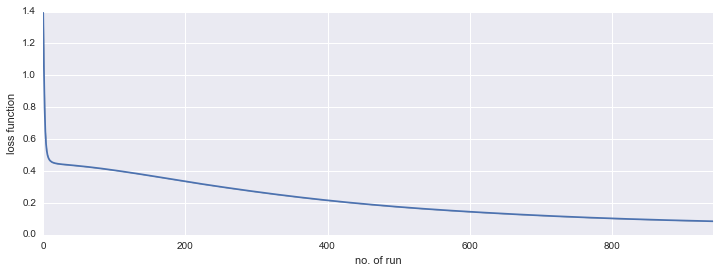

In [602]:
#run configuration
max_epoch = 5000
min_loss_criterion = 10**-4

#doing 1st forward pass to calculate loss
f_hid = sigmoid(w_hid,Xb)
f_hid_b = np.insert(f_hid,0,1,axis=1) #bias activation for next layer
f_out = sigmoid(w_out,f_hid_b)
curr_loss = loss_func(Y,f_out)
loss = []
loss.append(curr_loss)
print 'start_loss = {}'.format(curr_loss*2)

learning_rate = 0.7/instance_size
learning_rate_bias = 0.7/instance_size

for i in range(0,max_epoch):
    
    #update the weights of output layer
    delta_out = (f_out - Y)*(f_out)*(1-f_out) #element-wise operation 
    wgrad_out = np.einsum('ki,kj->ij', delta_out, f_hid) #dot operation already sums it up     
    w_out_bef = w_out.copy()
    w_out[:,1:] = w_out[:,1:] -learning_rate*(wgrad_out)
    w_out[:,0] = w_out[:,0] -learning_rate_bias*np.sum(delta_out,axis=0)*1.0

    #update the weights of hidden layer
    delta_hid = delta_out.dot(w_out_bef[:,1:])*(f_hid)*(1-f_hid) #dot then element-wise operation      
    wgrad_hid = np.einsum('ki,kj->ij',delta_hid,Xb[:,1:])
    w_hid[:,1:] = w_hid[:,1:] -learning_rate*wgrad_hid
    w_hid[:,0] = w_hid[:,0] -learning_rate_bias*np.sum(delta_hid,axis=0)*1.0
    
    #re-calculate loss
    f_hid = sigmoid(w_hid,Xb)
    f_hid_b = np.insert(f_hid,0,1,axis=1) #bias activation for next layer
    f_out = sigmoid(w_out,f_hid_b)
    curr_loss = loss_func(Y,f_out)
    loss.append(curr_loss)

    #stopping criterion
    if (i>10) and ((loss[-2] - curr_loss) < min_loss_criterion): 
        print 'stop at {}'.format(i)
        break

print 'end_loss = {}'.format(loss[-1])
        
plt.figure()
plt.xlabel('no. of run')
plt.ylabel('loss function')
sns.tsplot(loss)

[[177   0   0   0   0   1   1   0   0   0]
 [  0 170   0   0   2   1   1   0  15   2]
 [  0   1 176   3   0   0   0   0   2   0]
 [  0   0   0 177   0   0   0   0   2   1]
 [  1   0   0   0 176   0   0   1   0   0]
 [  0   2   0   2   0 176   0   0   4   3]
 [  0   2   0   0   0   1 179   0   3   0]
 [  0   0   1   0   1   1   0 177   1   5]
 [  0   3   0   1   1   0   0   1 145   3]
 [  0   4   0   0   1   2   0   0   2 166]]
Accuracy = 95.66%
Actually this is not true accuracy because we didn't verify it with the test dataset.


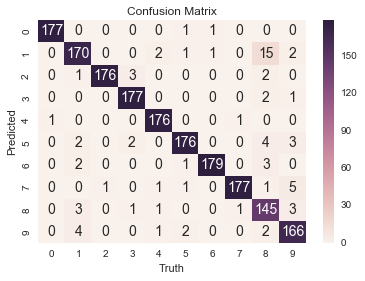

In [605]:
#get the prediction to compare with target
y_pred = np.argmax(f_out,axis=1)

from sklearn.metrics import confusion_matrix
cm_mat = confusion_matrix(digits.target[0:instance_size],y_pred)
print cm_mat.T
accuracy = np.trace(cm_mat)*100.0/instance_size
print 'Accuracy = {:.2f}%'.format(accuracy)
print 'Actually this is not true accuracy because we didn\'t verify it with the test dataset.'
df_temp = pd.DataFrame(cm_mat.flatten()[np.newaxis].T,columns = ['values'])
plt.figure(figsize = (6,4),dpi=600)
sns.heatmap(cm_mat.T, cbar=True ,annot=True, fmt=',.0f')
plt.title('Confusion Matrix')
plt.xlabel('Truth')
plt.ylabel('Predicted')